In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm


In [33]:

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

mps


In [46]:
path = "images/birds.png"
im = Image.open(path).convert("RGB")
im_tensor_cpu = to_tensor(im).to(device="cpu")
im_tensor_mps =to_tensor(im).to(device="mps") 
print(f"inital tensor size : {im_tensor_cpu.shape}")


max_dim = 250
_, H, W = im_tensor_mps.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_mps.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 164, 244])
rescaled tensor size : torch.Size([3, 168, 249])


In [47]:
min_dim = 25            # dimension mini au coarse scale
N = 0
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)

# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

7

In [48]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(1, N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


Number of scales N = 7
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 168, 249])


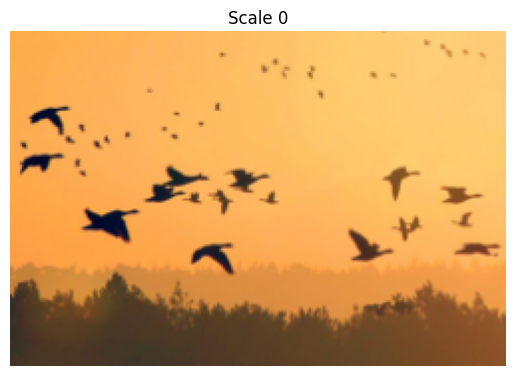

Scale 1 : torch.Size([1, 3, 126, 186])


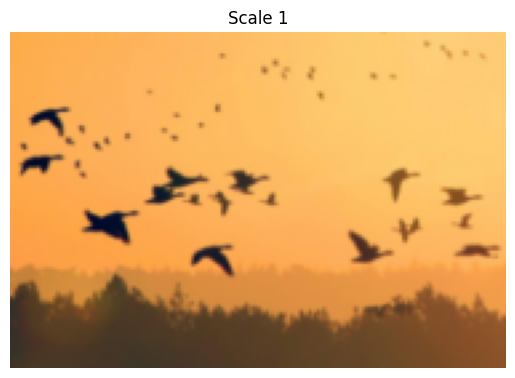

Scale 2 : torch.Size([1, 3, 94, 139])


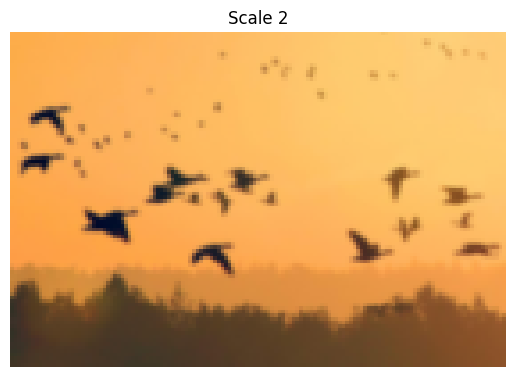

Scale 3 : torch.Size([1, 3, 70, 104])


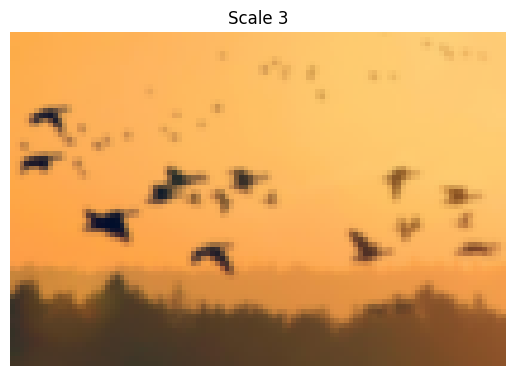

Scale 4 : torch.Size([1, 3, 52, 78])


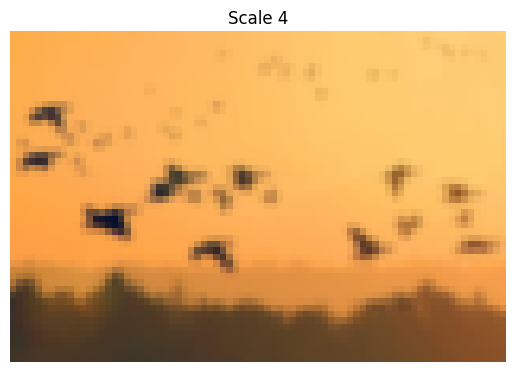

Scale 5 : torch.Size([1, 3, 39, 58])


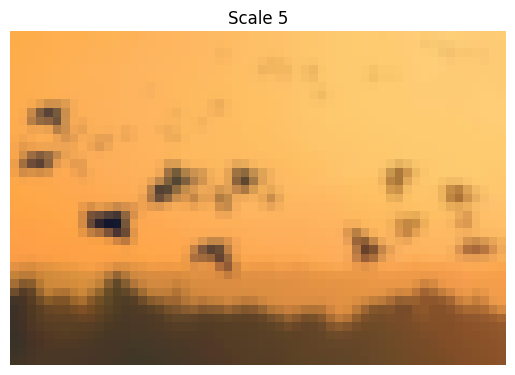

Scale 6 : torch.Size([1, 3, 29, 43])


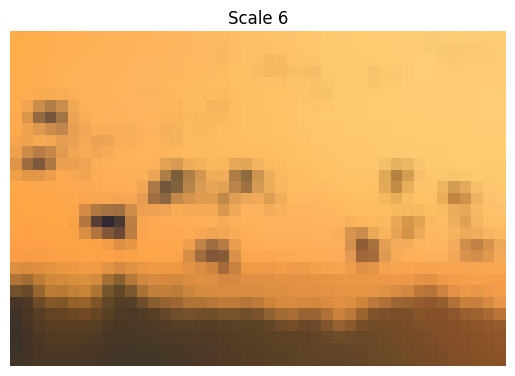

In [49]:
def pil_from_minus1to1(t):
    """
    Convertit un tenseur [-1,1] (C×H×W ou 1×C×H×W) en PIL Image.
    """
    t = t.squeeze(0) if t.dim() == 4 else t          # B×C×H×W → C×H×W
    t = ((t.clamp(-1, 1) + 1) / 2)                   # [-1,1] → [0,1]
    return to_pil_image(t.cpu())



print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(pil_from_minus1to1(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()


In [50]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [51]:
class Discriminator(nn.Module):
    def __init__(self,n_hidden):
        
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(3, self.n_hidden, kernel_size=3, padding=1),  
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, 1, 3, padding=1)  
        )
    
    def forward(self,input):
        return self.main(input)

In [52]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

In [53]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [54]:
hidden_lowest_dim = 32
Genarators = []
Discriminators = []

for i in range(N):
    r = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(r//4)).to(device))
    Discriminators.append(Discriminator(hidden_lowest_dim * 2**(r//4)).to(device))
    
Genarators.reverse()
Discriminators.reverse()

for gen in Genarators : 
     print(gen.n_hidden)
for dis in Discriminators:
     print(dis.n_hidden)


32
32
32
64
64
64
64
32
32
32
64
64
64
64


+ Boucle d'entrainement 

In [55]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


for G in Genarators:
    G.apply(weights_init)
for D in Discriminators:
    D.apply(weights_init)

it scale 6:   0%|          | 0/2500 [00:00<?, ?it/s]

[scale 6 | it 0]  Lips ≈ 0.03
[scale 6 | it 0]  LR = 5.00e-04


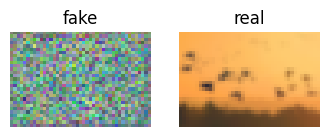

it scale 6:   8%|▊         | 199/2500 [00:14<02:43, 14.09it/s]

[scale 6 | it 200]  Lips ≈ 1.34
[scale 6 | it 200]  LR = 5.00e-04


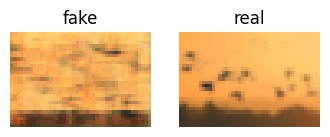

it scale 6:  16%|█▌        | 399/2500 [00:29<02:30, 14.00it/s]

[scale 6 | it 400]  Lips ≈ 1.22
[scale 6 | it 400]  LR = 5.00e-04


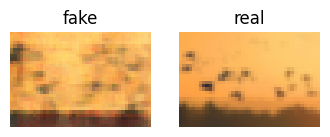

it scale 6:  24%|██▍       | 599/2500 [00:43<02:15, 14.03it/s]

[scale 6 | it 600]  Lips ≈ 1.36
[scale 6 | it 600]  LR = 5.00e-04


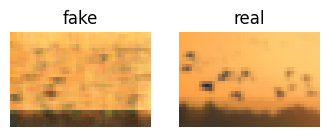

it scale 6:  32%|███▏      | 799/2500 [00:57<02:01, 14.03it/s]

[scale 6 | it 800]  Lips ≈ 1.32
[scale 6 | it 800]  LR = 5.00e-04


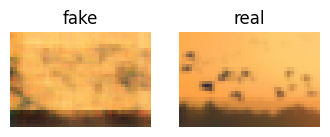

it scale 6:  40%|███▉      | 999/2500 [01:12<01:47, 14.02it/s]

[scale 6 | it 1000]  Lips ≈ 1.43
[scale 6 | it 1000]  LR = 5.00e-04


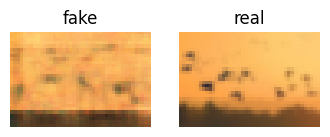

it scale 6:  48%|████▊     | 1199/2500 [01:26<01:32, 14.08it/s]

[scale 6 | it 1200]  Lips ≈ 1.13
[scale 6 | it 1200]  LR = 5.00e-04


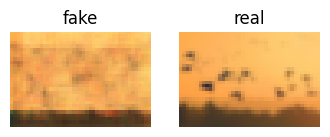

it scale 6:  56%|█████▌    | 1399/2500 [01:40<01:17, 14.21it/s]

[scale 6 | it 1400]  Lips ≈ 1.37
[scale 6 | it 1400]  LR = 5.00e-04


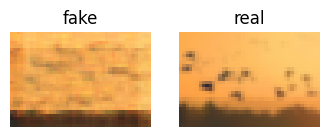

it scale 6:  64%|██████▍   | 1599/2500 [01:54<01:04, 14.02it/s]

[scale 6 | it 1600]  Lips ≈ 1.52
[scale 6 | it 1600]  LR = 5.00e-04


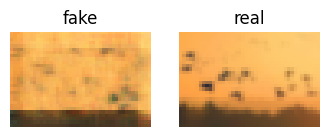

it scale 6:  72%|███████▏  | 1799/2500 [02:09<00:50, 13.97it/s]

[scale 6 | it 1800]  Lips ≈ 1.30
[scale 6 | it 1800]  LR = 5.00e-04


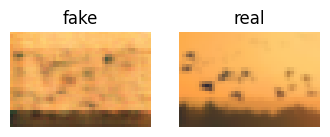

it scale 6:  80%|███████▉  | 1999/2500 [02:23<00:35, 14.00it/s]

[scale 6 | it 2000]  Lips ≈ 1.51
[scale 6 | it 2000]  LR = 5.00e-04


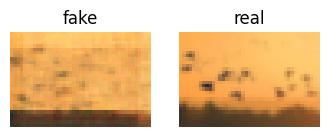

it scale 6:  88%|████████▊ | 2199/2500 [02:37<00:21, 14.28it/s]

[scale 6 | it 2200]  Lips ≈ 1.34
[scale 6 | it 2200]  LR = 5.00e-04


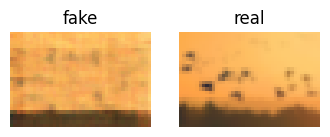

it scale 6:  96%|█████████▌| 2399/2500 [02:52<00:07, 14.14it/s]

[scale 6 | it 2400]  Lips ≈ 1.37
[scale 6 | it 2400]  LR = 5.00e-05


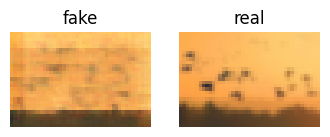

it scale 6: 100%|█████████▉| 2499/2500 [02:59<00:00, 13.99it/s]

[scale 6 | it 2499]  Lips ≈ 1.51
[scale 6 | it 2499]  LR = 5.00e-05


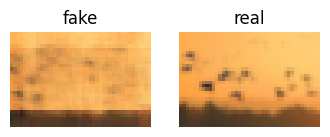

[init] copied weights from scale 6 → 5


it scale 5:   0%|          | 0/2500 [00:00<?, ?it/s]

[scale 5 | it 0]  Lips ≈ 1.21
[scale 5 | it 0]  LR = 5.00e-04


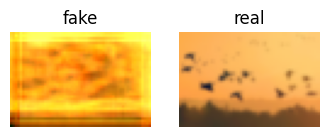

it scale 5:   8%|▊         | 199/2500 [00:15<02:47, 13.70it/s]

[scale 5 | it 200]  Lips ≈ 1.96
[scale 5 | it 200]  LR = 5.00e-04


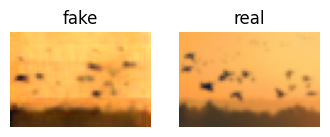

it scale 5:  16%|█▌        | 399/2500 [00:30<02:33, 13.73it/s]

[scale 5 | it 400]  Lips ≈ 1.36
[scale 5 | it 400]  LR = 5.00e-04


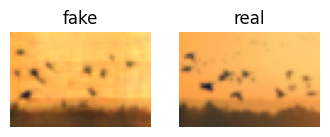

it scale 5:  24%|██▍       | 599/2500 [00:44<02:20, 13.49it/s]

[scale 5 | it 600]  Lips ≈ 1.52
[scale 5 | it 600]  LR = 5.00e-04


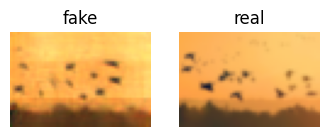

it scale 5:  32%|███▏      | 799/2500 [00:59<02:05, 13.55it/s]

[scale 5 | it 800]  Lips ≈ 1.50
[scale 5 | it 800]  LR = 5.00e-04


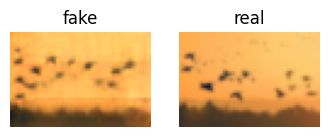

it scale 5:  40%|███▉      | 999/2500 [01:14<01:48, 13.79it/s]

[scale 5 | it 1000]  Lips ≈ 2.04
[scale 5 | it 1000]  LR = 5.00e-04


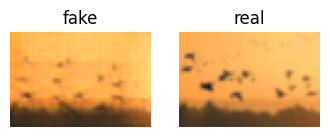

it scale 5:  48%|████▊     | 1199/2500 [01:28<01:36, 13.53it/s]

[scale 5 | it 1200]  Lips ≈ 1.25
[scale 5 | it 1200]  LR = 5.00e-04


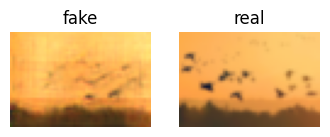

it scale 5:  56%|█████▌    | 1399/2500 [01:43<01:19, 13.78it/s]

[scale 5 | it 1400]  Lips ≈ 1.24
[scale 5 | it 1400]  LR = 5.00e-04


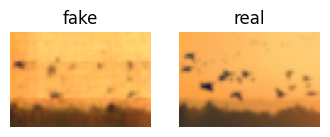

it scale 5:  64%|██████▍   | 1599/2500 [01:58<01:05, 13.72it/s]

[scale 5 | it 1600]  Lips ≈ 1.82
[scale 5 | it 1600]  LR = 5.00e-04


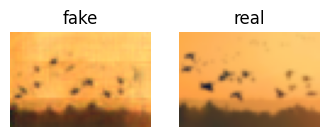

it scale 5:  72%|███████▏  | 1799/2500 [02:12<00:51, 13.67it/s]

[scale 5 | it 1800]  Lips ≈ 1.59
[scale 5 | it 1800]  LR = 5.00e-04


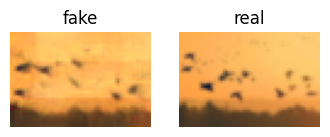

it scale 5:  80%|███████▉  | 1999/2500 [02:27<00:36, 13.72it/s]

[scale 5 | it 2000]  Lips ≈ 1.43
[scale 5 | it 2000]  LR = 5.00e-04


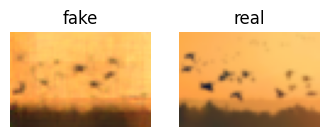

it scale 5:  88%|████████▊ | 2199/2500 [02:42<00:23, 12.65it/s]

[scale 5 | it 2200]  Lips ≈ 1.37
[scale 5 | it 2200]  LR = 5.00e-04


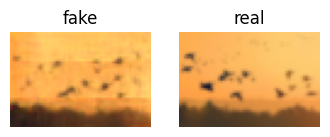

it scale 5:  96%|█████████▌| 2400/2500 [03:02<00:08, 11.33it/s]

[scale 5 | it 2400]  Lips ≈ 1.43
[scale 5 | it 2400]  LR = 5.00e-05


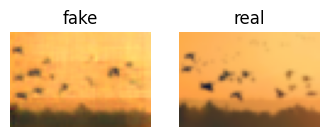

it scale 5: 100%|█████████▉| 2498/2500 [03:10<00:00, 10.87it/s]

[scale 5 | it 2499]  Lips ≈ 1.63
[scale 5 | it 2499]  LR = 5.00e-05


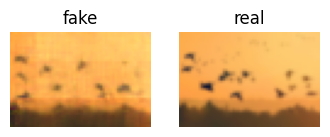

[init] copied weights from scale 5 → 4


it scale 4:   0%|          | 0/2500 [00:00<?, ?it/s]

[scale 4 | it 0]  Lips ≈ 1.49
[scale 4 | it 0]  LR = 5.00e-04


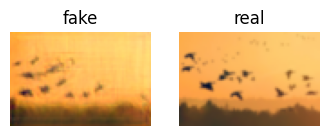

it scale 4:   8%|▊         | 200/2500 [00:25<04:40,  8.20it/s]

[scale 4 | it 200]  Lips ≈ 1.39
[scale 4 | it 200]  LR = 5.00e-04


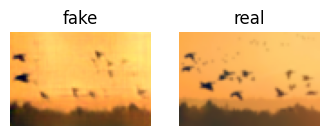

it scale 4:  16%|█▌        | 400/2500 [00:49<03:57,  8.83it/s]

[scale 4 | it 400]  Lips ≈ 1.47
[scale 4 | it 400]  LR = 5.00e-04


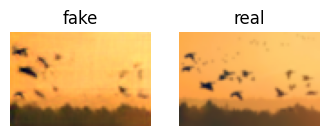

it scale 4:  24%|██▍       | 600/2500 [01:12<03:36,  8.78it/s]

[scale 4 | it 600]  Lips ≈ 1.46
[scale 4 | it 600]  LR = 5.00e-04


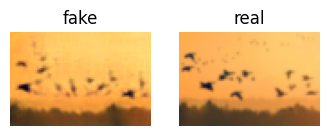

it scale 4:  32%|███▏      | 800/2500 [01:35<03:14,  8.74it/s]

[scale 4 | it 800]  Lips ≈ 1.22
[scale 4 | it 800]  LR = 5.00e-04


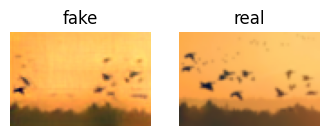

it scale 4:  40%|████      | 1000/2500 [01:58<02:46,  9.03it/s]

[scale 4 | it 1000]  Lips ≈ 1.22
[scale 4 | it 1000]  LR = 5.00e-04


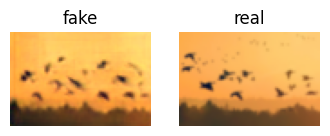

it scale 4:  48%|████▊     | 1200/2500 [02:21<02:26,  8.85it/s]

[scale 4 | it 1200]  Lips ≈ 1.18
[scale 4 | it 1200]  LR = 5.00e-04


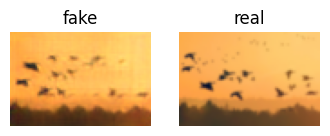

it scale 4:  56%|█████▌    | 1400/2500 [02:44<02:06,  8.70it/s]

[scale 4 | it 1400]  Lips ≈ 1.15
[scale 4 | it 1400]  LR = 5.00e-04


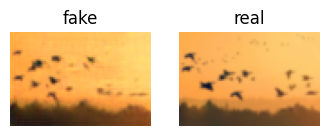

it scale 4:  64%|██████▍   | 1600/2500 [03:07<01:45,  8.55it/s]

[scale 4 | it 1600]  Lips ≈ 1.72
[scale 4 | it 1600]  LR = 5.00e-04


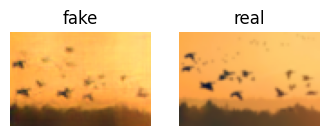

it scale 4:  72%|███████▏  | 1800/2500 [03:30<01:18,  8.92it/s]

[scale 4 | it 1800]  Lips ≈ 2.29
[scale 4 | it 1800]  LR = 5.00e-04


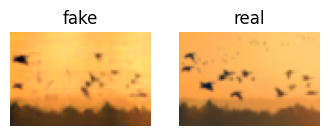

it scale 4:  80%|████████  | 2000/2500 [03:53<00:58,  8.47it/s]

[scale 4 | it 2000]  Lips ≈ 1.17
[scale 4 | it 2000]  LR = 5.00e-04


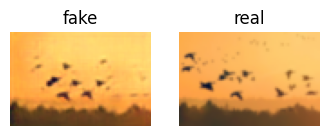

it scale 4:  88%|████████▊ | 2200/2500 [04:16<00:35,  8.41it/s]

[scale 4 | it 2200]  Lips ≈ 1.24
[scale 4 | it 2200]  LR = 5.00e-04


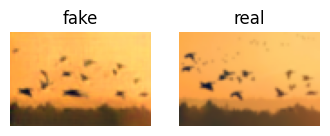

it scale 4:  96%|█████████▌| 2400/2500 [04:39<00:11,  8.81it/s]

[scale 4 | it 2400]  Lips ≈ 0.93
[scale 4 | it 2400]  LR = 5.00e-05


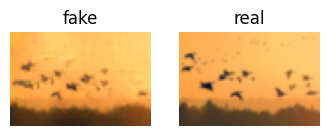

it scale 4: 100%|█████████▉| 2499/2500 [04:50<00:00,  8.71it/s]

[scale 4 | it 2499]  Lips ≈ 1.82
[scale 4 | it 2499]  LR = 5.00e-05


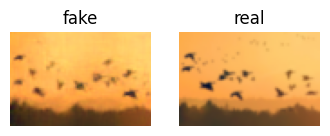

[init] copied weights from scale 4 → 3


it scale 3:   0%|          | 0/2500 [00:00<?, ?it/s]

[scale 3 | it 0]  Lips ≈ 1.42
[scale 3 | it 0]  LR = 5.00e-04


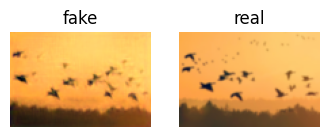

it scale 3:   8%|▊         | 200/2500 [00:39<07:28,  5.12it/s]

[scale 3 | it 200]  Lips ≈ 1.24
[scale 3 | it 200]  LR = 5.00e-04


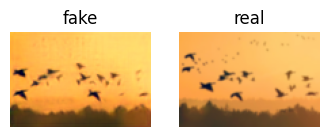

it scale 3:  16%|█▌        | 400/2500 [01:18<06:53,  5.08it/s]

[scale 3 | it 400]  Lips ≈ 1.50
[scale 3 | it 400]  LR = 5.00e-04


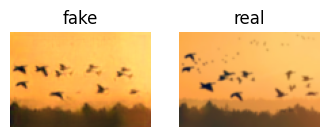

it scale 3:  24%|██▍       | 600/2500 [01:57<06:10,  5.12it/s]

[scale 3 | it 600]  Lips ≈ 1.15
[scale 3 | it 600]  LR = 5.00e-04


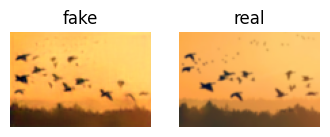

it scale 3:  32%|███▏      | 800/2500 [02:36<05:28,  5.18it/s]

[scale 3 | it 800]  Lips ≈ 1.25
[scale 3 | it 800]  LR = 5.00e-04


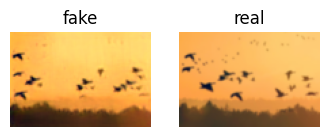

it scale 3:  40%|████      | 1000/2500 [03:16<05:05,  4.91it/s]

[scale 3 | it 1000]  Lips ≈ 1.25
[scale 3 | it 1000]  LR = 5.00e-04


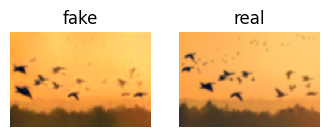

it scale 3:  48%|████▊     | 1200/2500 [03:59<05:20,  4.06it/s]

[scale 3 | it 1200]  Lips ≈ 1.22
[scale 3 | it 1200]  LR = 5.00e-04


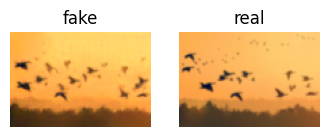

it scale 3:  56%|█████▌    | 1400/2500 [04:43<03:58,  4.60it/s]

[scale 3 | it 1400]  Lips ≈ 1.15
[scale 3 | it 1400]  LR = 5.00e-04


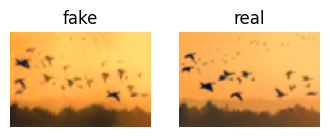

it scale 3:  64%|██████▍   | 1600/2500 [05:27<03:12,  4.68it/s]

[scale 3 | it 1600]  Lips ≈ 1.18
[scale 3 | it 1600]  LR = 5.00e-04


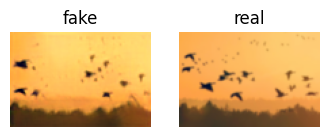

it scale 3:  72%|███████▏  | 1800/2500 [07:06<06:10,  1.89it/s]

[scale 3 | it 1800]  Lips ≈ 2.65
[scale 3 | it 1800]  LR = 5.00e-04


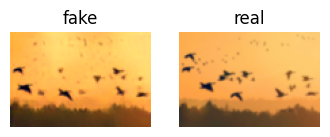

it scale 3:  80%|████████  | 2000/2500 [08:53<04:29,  1.86it/s]

[scale 3 | it 2000]  Lips ≈ 1.88
[scale 3 | it 2000]  LR = 5.00e-04


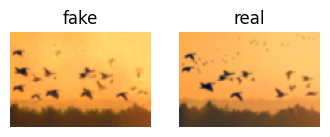

it scale 3:  88%|████████▊ | 2200/2500 [10:39<02:35,  1.93it/s]

[scale 3 | it 2200]  Lips ≈ 1.15
[scale 3 | it 2200]  LR = 5.00e-04


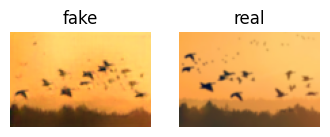

it scale 3:  96%|█████████▌| 2400/2500 [12:24<00:53,  1.86it/s]

[scale 3 | it 2400]  Lips ≈ 1.95
[scale 3 | it 2400]  LR = 5.00e-05


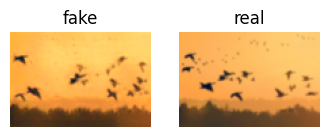

it scale 3: 100%|█████████▉| 2499/2500 [13:17<00:00,  1.87it/s]

[scale 3 | it 2499]  Lips ≈ 1.68
[scale 3 | it 2499]  LR = 5.00e-05


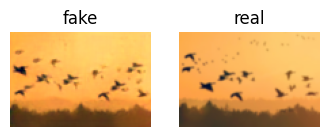

it scale 2:   0%|          | 0/2500 [00:00<?, ?it/s]           

[scale 2 | it 0]  Lips ≈ 0.01
[scale 2 | it 0]  LR = 5.00e-04


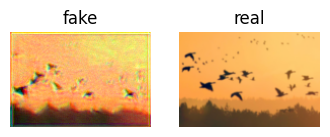

it scale 2:   8%|▊         | 200/2500 [01:21<15:24,  2.49it/s]

[scale 2 | it 200]  Lips ≈ 1.07
[scale 2 | it 200]  LR = 5.00e-04


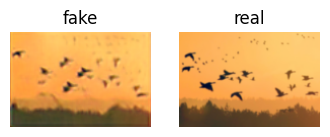

it scale 2:  16%|█▌        | 400/2500 [02:41<13:44,  2.55it/s]

[scale 2 | it 400]  Lips ≈ 0.82
[scale 2 | it 400]  LR = 5.00e-04


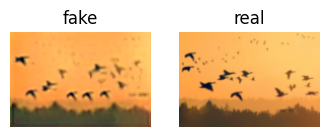

it scale 2:  24%|██▍       | 600/2500 [04:00<12:45,  2.48it/s]

[scale 2 | it 600]  Lips ≈ 0.81
[scale 2 | it 600]  LR = 5.00e-04


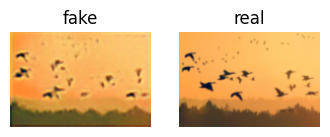

it scale 2:  32%|███▏      | 800/2500 [05:19<11:16,  2.51it/s]

[scale 2 | it 800]  Lips ≈ 1.15
[scale 2 | it 800]  LR = 5.00e-04


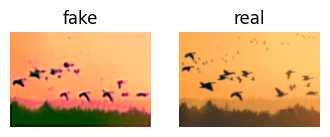

it scale 2:  40%|████      | 1000/2500 [06:38<09:37,  2.60it/s]

[scale 2 | it 1000]  Lips ≈ 1.44
[scale 2 | it 1000]  LR = 5.00e-04


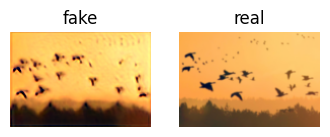

it scale 2:  48%|████▊     | 1200/2500 [07:57<08:22,  2.59it/s]

[scale 2 | it 1200]  Lips ≈ 1.11
[scale 2 | it 1200]  LR = 5.00e-04


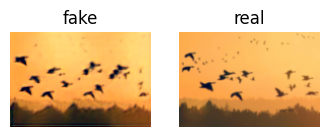

it scale 2:  56%|█████▌    | 1400/2500 [09:15<07:08,  2.57it/s]

[scale 2 | it 1400]  Lips ≈ 1.08
[scale 2 | it 1400]  LR = 5.00e-04


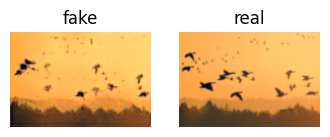

it scale 2:  64%|██████▍   | 1600/2500 [10:34<05:57,  2.51it/s]

[scale 2 | it 1600]  Lips ≈ 1.11
[scale 2 | it 1600]  LR = 5.00e-04


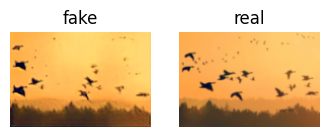

it scale 2:  72%|███████▏  | 1800/2500 [11:53<04:31,  2.57it/s]

[scale 2 | it 1800]  Lips ≈ 0.83
[scale 2 | it 1800]  LR = 5.00e-04


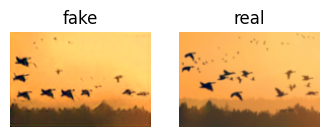

it scale 2:  80%|████████  | 2000/2500 [13:10<03:11,  2.61it/s]

[scale 2 | it 2000]  Lips ≈ 1.23
[scale 2 | it 2000]  LR = 5.00e-04


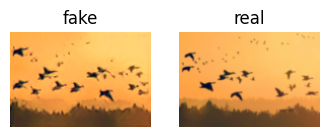

it scale 2:  88%|████████▊ | 2200/2500 [14:26<01:54,  2.62it/s]

[scale 2 | it 2200]  Lips ≈ 1.08
[scale 2 | it 2200]  LR = 5.00e-04


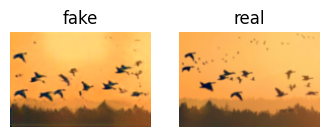

it scale 2:  96%|█████████▌| 2400/2500 [15:44<00:39,  2.54it/s]

[scale 2 | it 2400]  Lips ≈ 1.21
[scale 2 | it 2400]  LR = 5.00e-05


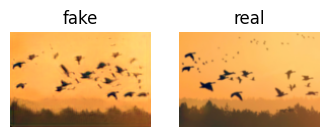

it scale 2: 100%|█████████▉| 2499/2500 [16:22<00:00,  2.58it/s]

[scale 2 | it 2499]  Lips ≈ 1.06
[scale 2 | it 2499]  LR = 5.00e-05


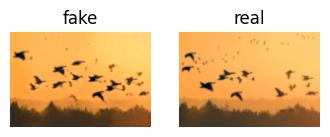

[init] copied weights from scale 2 → 1


it scale 1:   0%|          | 0/2500 [00:00<?, ?it/s]

[scale 1 | it 0]  Lips ≈ 0.95
[scale 1 | it 0]  LR = 5.00e-04


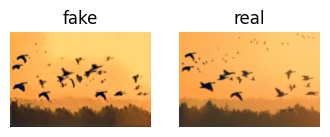

it scale 1:   8%|▊         | 200/2500 [02:02<23:29,  1.63it/s]

[scale 1 | it 200]  Lips ≈ 0.91
[scale 1 | it 200]  LR = 5.00e-04


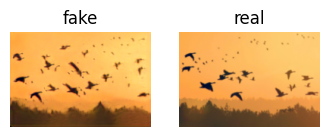

it scale 1:  16%|█▌        | 400/2500 [04:07<21:52,  1.60it/s]

[scale 1 | it 400]  Lips ≈ 1.31
[scale 1 | it 400]  LR = 5.00e-04


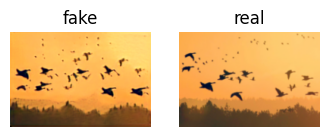

it scale 1:  24%|██▍       | 600/2500 [06:12<20:00,  1.58it/s]

[scale 1 | it 600]  Lips ≈ 1.43
[scale 1 | it 600]  LR = 5.00e-04


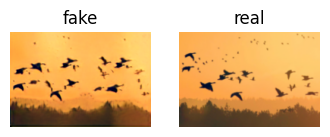

it scale 1:  32%|███▏      | 800/2500 [08:16<17:05,  1.66it/s]

[scale 1 | it 800]  Lips ≈ 1.45
[scale 1 | it 800]  LR = 5.00e-04


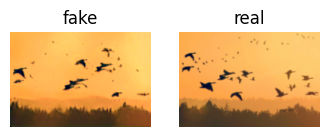

it scale 1:  40%|████      | 1000/2500 [10:19<15:13,  1.64it/s]

[scale 1 | it 1000]  Lips ≈ 1.14
[scale 1 | it 1000]  LR = 5.00e-04


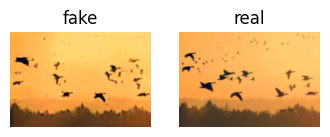

it scale 1:  48%|████▊     | 1200/2500 [12:22<13:08,  1.65it/s]

[scale 1 | it 1200]  Lips ≈ 1.31
[scale 1 | it 1200]  LR = 5.00e-04


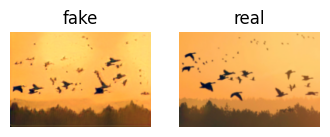

it scale 1:  56%|█████▌    | 1400/2500 [14:25<11:21,  1.62it/s]

[scale 1 | it 1400]  Lips ≈ 1.04
[scale 1 | it 1400]  LR = 5.00e-04


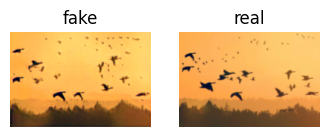

it scale 1:  64%|██████▍   | 1600/2500 [16:27<09:03,  1.66it/s]

[scale 1 | it 1600]  Lips ≈ 1.16
[scale 1 | it 1600]  LR = 5.00e-04


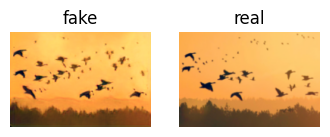

it scale 1:  72%|███████▏  | 1800/2500 [18:30<07:15,  1.61it/s]

[scale 1 | it 1800]  Lips ≈ 1.06
[scale 1 | it 1800]  LR = 5.00e-04


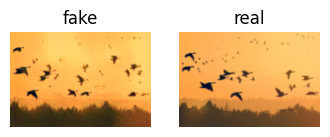

it scale 1:  80%|████████  | 2000/2500 [20:33<05:04,  1.64it/s]

[scale 1 | it 2000]  Lips ≈ 1.15
[scale 1 | it 2000]  LR = 5.00e-04


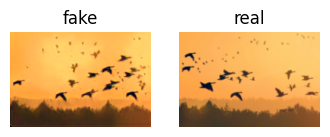

it scale 1:  88%|████████▊ | 2200/2500 [22:36<03:04,  1.63it/s]

[scale 1 | it 2200]  Lips ≈ 1.94
[scale 1 | it 2200]  LR = 5.00e-04


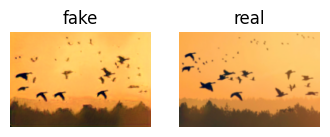

it scale 1:  96%|█████████▌| 2400/2500 [24:40<01:02,  1.61it/s]

[scale 1 | it 2400]  Lips ≈ 1.17
[scale 1 | it 2400]  LR = 5.00e-05


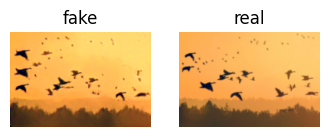

it scale 1: 100%|█████████▉| 2499/2500 [25:41<00:00,  1.63it/s]

[scale 1 | it 2499]  Lips ≈ 1.46
[scale 1 | it 2499]  LR = 5.00e-05


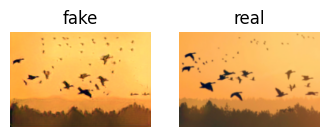

[init] copied weights from scale 1 → 0


it scale 0:   0%|          | 0/2500 [00:00<?, ?it/s]

[scale 0 | it 0]  Lips ≈ 1.27
[scale 0 | it 0]  LR = 5.00e-04


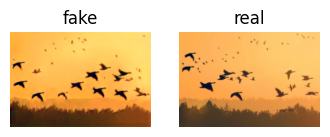

it scale 0:   8%|▊         | 200/2500 [03:30<39:35,  1.03s/it]

[scale 0 | it 200]  Lips ≈ 1.46
[scale 0 | it 200]  LR = 5.00e-04


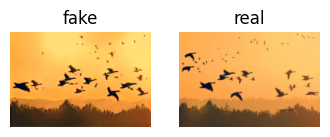

it scale 0:  16%|█▌        | 400/2500 [07:02<37:01,  1.06s/it]

[scale 0 | it 400]  Lips ≈ 1.46
[scale 0 | it 400]  LR = 5.00e-04


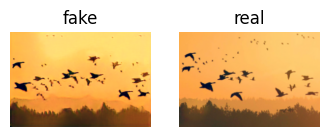

it scale 0:  24%|██▍       | 600/2500 [10:18<16:29,  1.92it/s]

[scale 0 | it 600]  Lips ≈ 1.21
[scale 0 | it 600]  LR = 5.00e-04


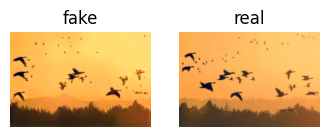

it scale 0:  32%|███▏      | 800/2500 [12:06<15:43,  1.80it/s]

[scale 0 | it 800]  Lips ≈ 1.24
[scale 0 | it 800]  LR = 5.00e-04


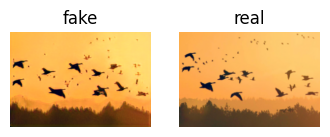

it scale 0:  40%|████      | 1000/2500 [13:52<12:53,  1.94it/s]

[scale 0 | it 1000]  Lips ≈ 1.51
[scale 0 | it 1000]  LR = 5.00e-04


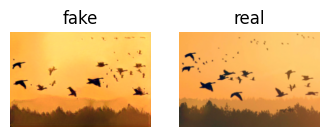

it scale 0:  48%|████▊     | 1200/2500 [15:36<11:20,  1.91it/s]

[scale 0 | it 1200]  Lips ≈ 1.14
[scale 0 | it 1200]  LR = 5.00e-04


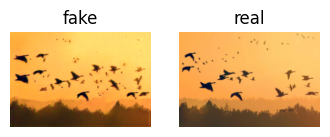

it scale 0:  56%|█████▌    | 1400/2500 [17:21<09:35,  1.91it/s]

[scale 0 | it 1400]  Lips ≈ 1.07
[scale 0 | it 1400]  LR = 5.00e-04


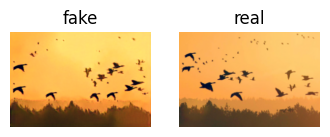

it scale 0:  64%|██████▍   | 1600/2500 [19:05<07:48,  1.92it/s]

[scale 0 | it 1600]  Lips ≈ 1.33
[scale 0 | it 1600]  LR = 5.00e-04


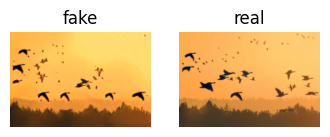

it scale 0:  72%|███████▏  | 1800/2500 [20:49<06:05,  1.92it/s]

[scale 0 | it 1800]  Lips ≈ 1.82
[scale 0 | it 1800]  LR = 5.00e-04


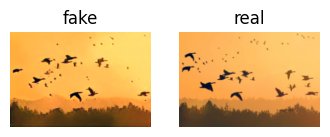

it scale 0:  80%|████████  | 2000/2500 [22:33<04:18,  1.94it/s]

[scale 0 | it 2000]  Lips ≈ 1.99
[scale 0 | it 2000]  LR = 5.00e-04


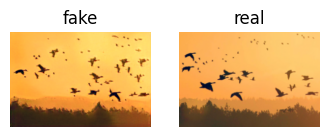

it scale 0:  88%|████████▊ | 2200/2500 [24:18<02:37,  1.90it/s]

[scale 0 | it 2200]  Lips ≈ 1.25
[scale 0 | it 2200]  LR = 5.00e-04


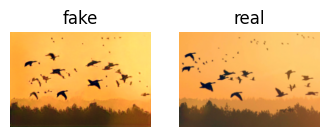

it scale 0:  96%|█████████▌| 2400/2500 [26:02<00:52,  1.91it/s]

[scale 0 | it 2400]  Lips ≈ 2.07
[scale 0 | it 2400]  LR = 5.00e-05


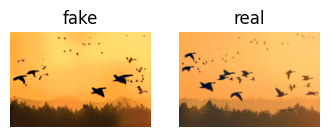

it scale 0: 100%|█████████▉| 2499/2500 [26:54<00:00,  1.94it/s]

[scale 0 | it 2499]  Lips ≈ 1.30
[scale 0 | it 2499]  LR = 5.00e-05


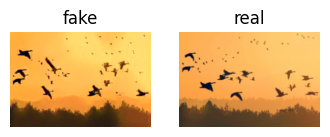

In [56]:
torch.random.manual_seed(0)

# params
lambda_gp    = 10
lr             = 5e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 3 # pif
n_Generator      = 3 # pif
iter_per_scale   = 2500 # github
alpha_rec      = 10 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1                                      # batch size

# reset des optim. #schedulers ???
optimizer_G, optimizer_D = [], []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))
    optimizer_D.append(optim.Adam(Discriminators[i].parameters(), lr=lr, betas=betas))

# --- LR schedulers -----------------------------------------------------------
# Each StepLR will keep the LR unchanged for 1 600 iterations, then multiply it
# by 0.1 once, and keep the new value for the remaining ~400 iterations.
scheduler_G, scheduler_D = [], []

step_size   = 2400          # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G, opt_D in zip(optimizer_G, optimizer_D):
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )
    scheduler_D.append(
        torch.optim.lr_scheduler.StepLR(opt_D, step_size=step_size, gamma=gamma)
    )


z_star   = torch.randn_like(scales[-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(scales[-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev(k):
    # k : res actuelle
    # retourne une nouvelle image avec le générateur précedent.
    # reprend la dernière image généré et rajoute du bruit puis upsample`
    if k == N-1:
        return torch.zeros_like(scales[k]).to(device)

    low_prev = gen_image[-1]                           
    z_prev   = torch.randn_like(low_prev) * sigma_n[k+1]
    low_fake = Genarators[k+1](z_prev + low_prev) + low_prev

    prev_img = F.interpolate(low_fake,
                             size=scales[k].shape[2:], 
                             mode='bilinear', align_corners=False)
    return prev_img

@torch.no_grad()
def regenerate_prev_full(k):
    """
    Reconstruit un prev_img pour l'échelle k en:
      +  partant d'une image nulle au coarse (N-1),
      + appliquant *tous* les G gelés (N-1 … k+1) avec nouveau bruit,
      +  upsamplant le résultat (k+1) → résolution de k.
    """
    if k == N-1:                                    # échelle coarse → zeros
        return torch.zeros_like(scales[k]).to(device)

    # scale la plus petite
    img = torch.zeros_like(scales[-1]).to(device)   
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Genarators[N-1](z)                       

    # on remonte le réseau
    for s in range(N-2, k, -1):                     
        img_up = F.interpolate(img,
                               size=scales[s].shape[2:],
                               mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Genarators[s](z + img_up) + img_up

    prev_img = F.interpolate(img,
                             size=scales[k].shape[2:],
                             mode='bilinear', align_corners=False)
    return prev_img

def lipconstant(D, x, y):
    
    b = x.size(0)
    if y.size(0) != b:
        raise ValueError("batch sizes differ")

    alpha = torch.rand((b,1,1,1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_(True)

    Di = D(interp).mean()                    # mean sinon ça me donnait des truc abbérant
    gradients = torch.autograd.grad(
        outputs=Di, inputs=interp,
        grad_outputs=torch.ones_like(Di),    
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    eps = 1e-12
    gradients_norm = torch.sqrt(gradients.flatten(1).pow(2).sum(1) + eps)
    return gradients_norm.mean()

# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    Dk = Discriminators[current_res].train()
    xk_real = scales[current_res].to(device)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]
        D_prev = Discriminators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            Dk.load_state_dict(D_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train();  Dk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    opt_D = optimizer_D[current_res]
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(1, device=device)

    # itérations par scale
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):

        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res)

        # trainning discriminateur
        for _ in range(n_Discriminator):
            opt_D.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img

            loss_D = Dk(fake.detach()).mean() - Dk(xk_real).mean()

            # gradient penalty
            alpha = torch.rand(b,1,1,1,device=device)
            interp = (alpha*xk_real + (1-alpha)*fake.detach()).requires_grad_(True)
            grad_out = Dk(interp).mean()
            grad = torch.autograd.grad(grad_out, interp, torch.ones_like(grad_out),
                                       create_graph=True, retain_graph=True, only_inputs=True)[0]
            gp = lambda_gp * ((grad.flatten(1).norm(2,dim=1)-1)**2).mean()
            (loss_D + gp).backward()
            opt_D.step()

        # trainning gen
        opt_G.zero_grad()

        for g_idx in range(n_Generator):
            # z = torch.randn_like(prev_img) * sigma_n[current_res]
            # fake = Gk(z + prev_img) + prev_img
            adv_G = -Dk(fake).mean()

            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec = F.mse_loss(rec_out, xk_real)
            keep_graph = g_idx < n_Generator - 1
            (adv_G + alpha_rec * Lrec).backward(retain_graph=keep_graph)
        opt_G.step()
        
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_D[current_res].step()
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 200 == 0 or it==iter_per_scale-1):
            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            lips = lipconstant(Dk, fake.detach(), xk_real)
            print(f"[scale {current_res} | it {it}]  Lips ≈ {lips:.2f}")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  LR = {current_lr:.2e}")

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake.detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)


In [98]:
@torch.no_grad()
def generate_multiscale(start_scale: int = N - 1):
    """
    start_scale = 0  → on ne renouvelle le bruit qu’à la fine scale
    start_scale = N-1→ on renouvelle le bruit à toutes les échelles
    """
    # Génération totale
    if start_scale == N-1 : 
        h, w = scales[-1].shape[2:]
        gen_image = [torch.zeros((1, 3, h, w), device=device)]

         # 2. on remonte coarse → fine
        for i in range(N):
            k = N - 1 - i                    
        
            prev = gen_image[-1]
            if prev.shape[2:] != scales[k].shape[2:]:
                prev = F.interpolate(prev, size=scales[k].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[k]
            

            x_k = Genarators[k](z + prev) + prev
            gen_image.append(x_k)

        

    else : 
        low = scales[start_scale+1] 
        up = F.interpolate(low, size=scales[start_scale].shape[2:],
                                    mode='bilinear', align_corners=False)
        gen_image = [up]

         # 2. on remonte coarse → fine
        for scale in range(start_scale,-1,-1):
                            
            prev = gen_image[-1]
            if prev.shape[2:] != scales[scale].shape[2:]:
                prev = F.interpolate(prev, size=scales[scale].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[scale]
            x_k = Genarators[scale](z + prev) + prev
            gen_image.append(x_k)

    
    return gen_image[1:]
        
    


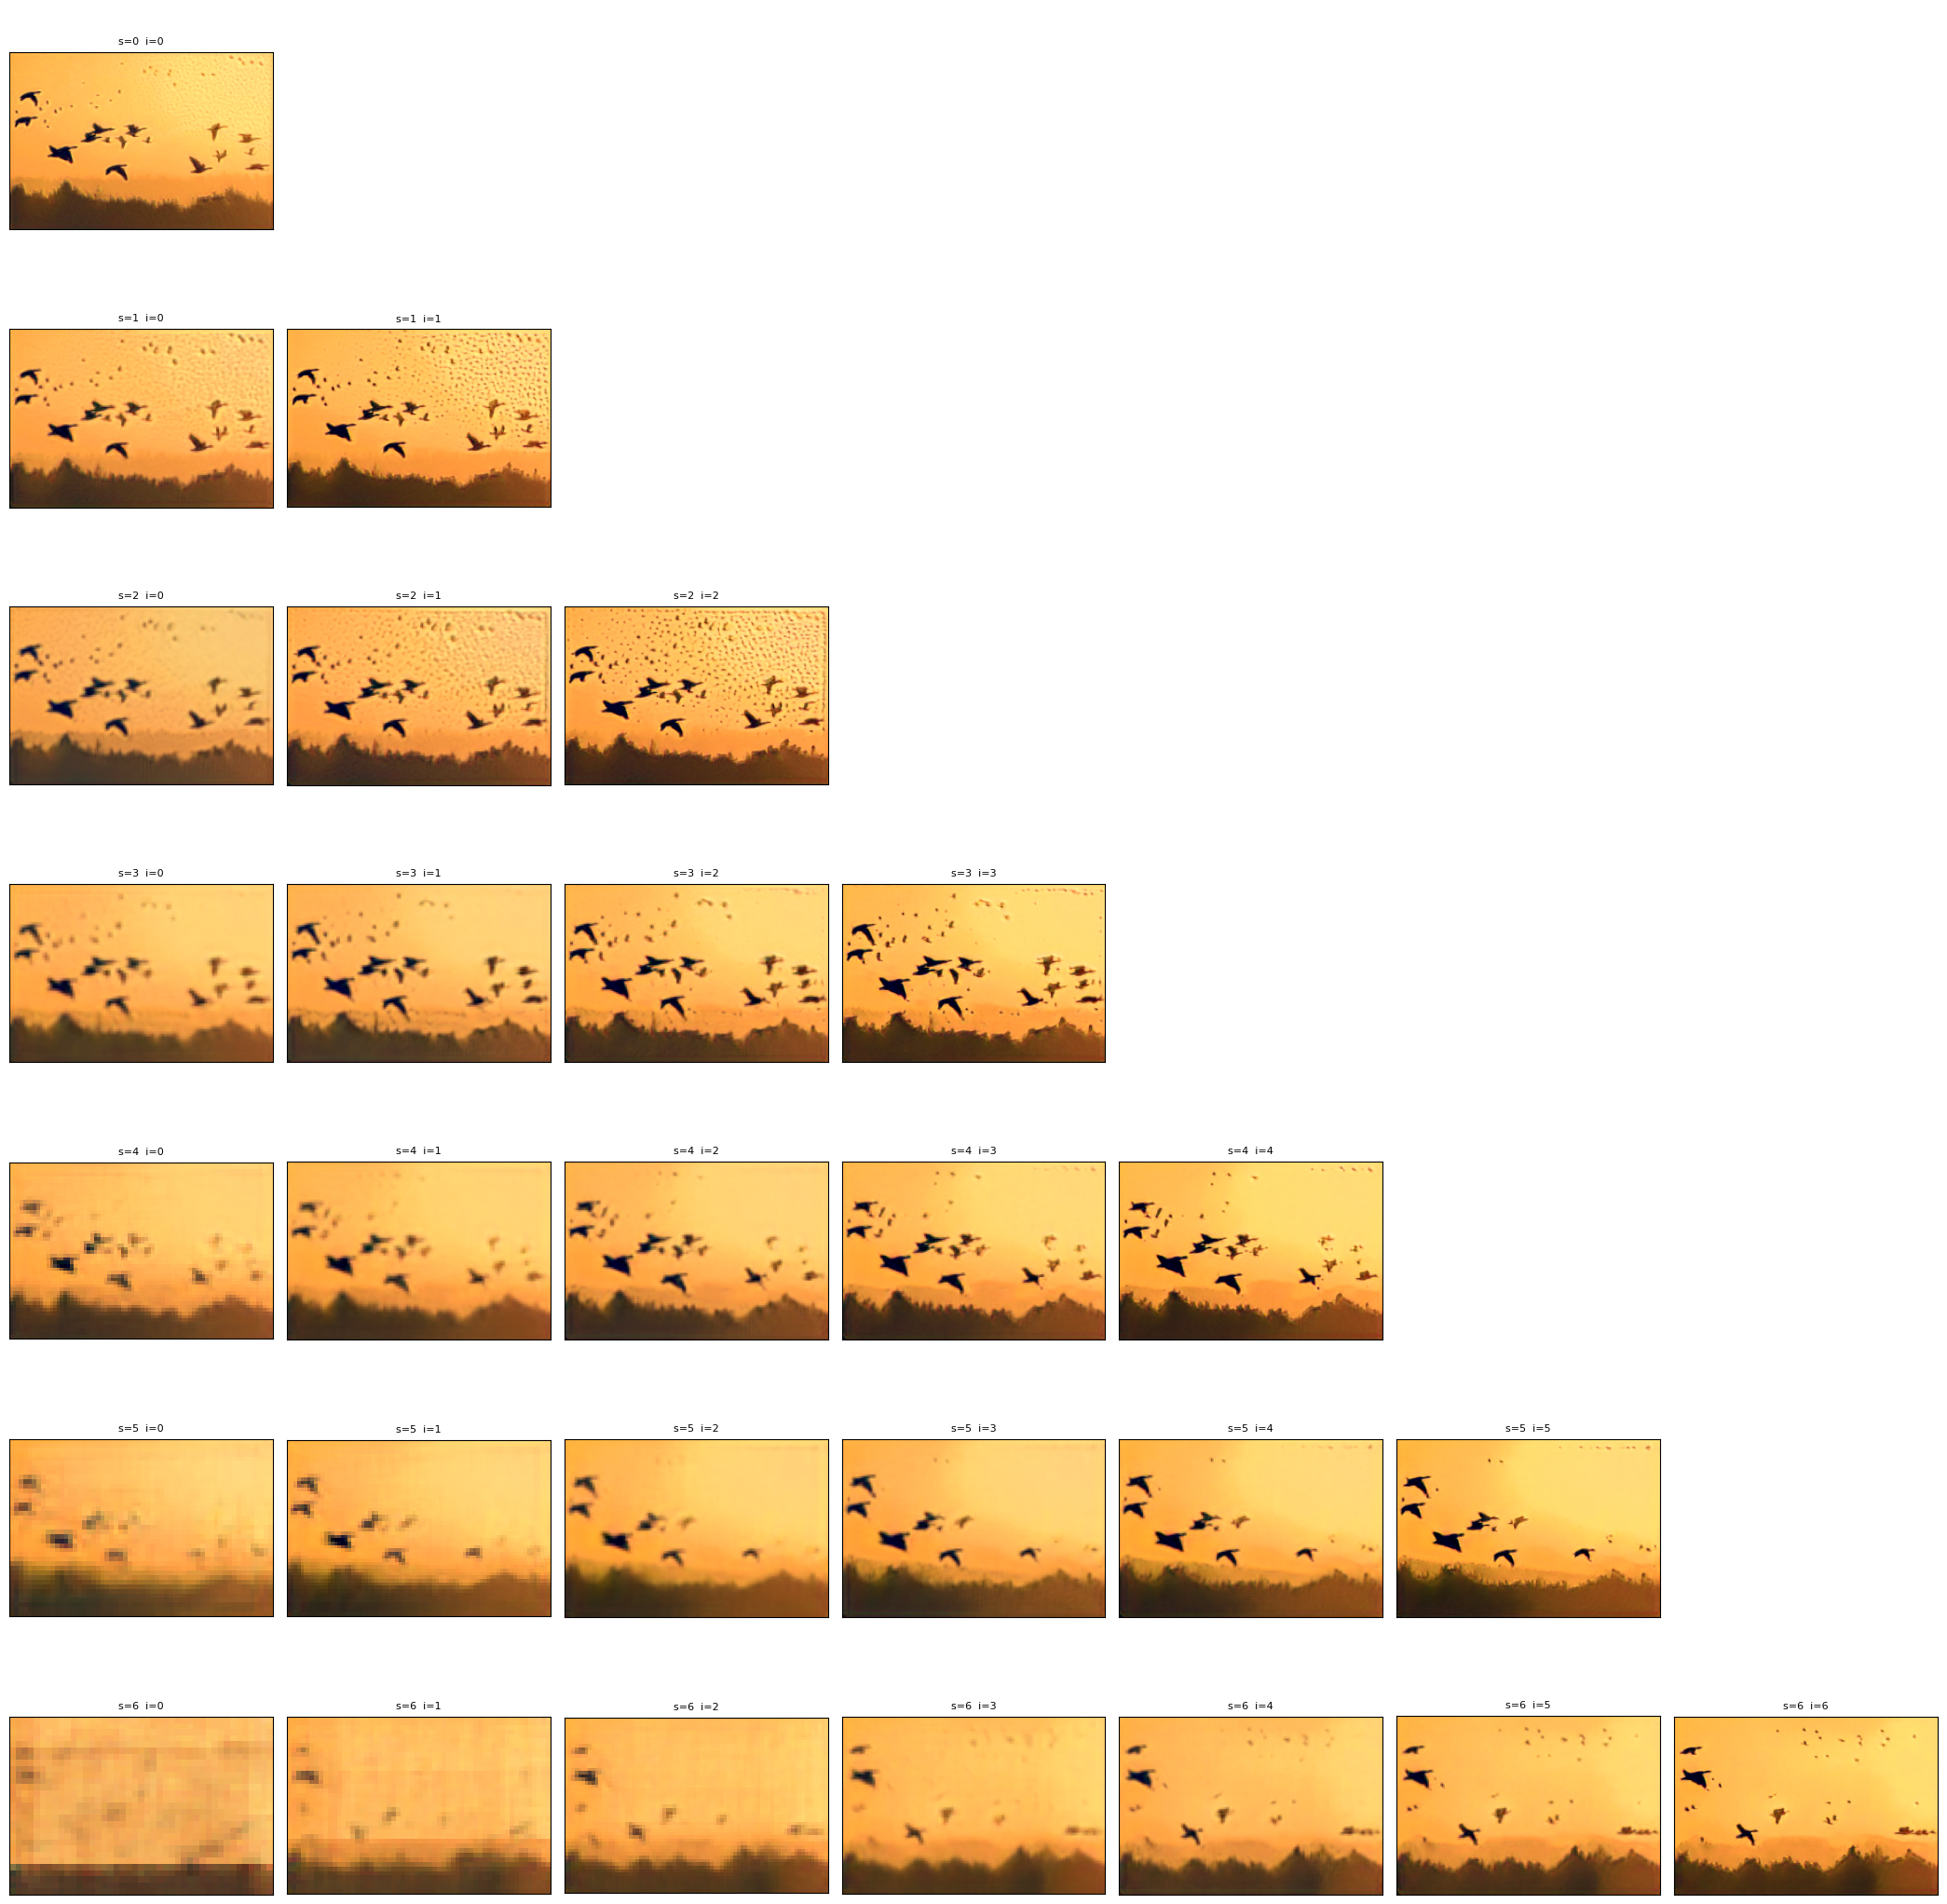

In [99]:
# 1. Collecter toutes les images pour connaître la taille de la grille
rows      = []                 # liste des listes d’images (Tensor)
max_cols  = 0
for s in range(N):
    imgs = generate_multiscale(start_scale=s)   # list[Tensor]
    rows.append(imgs)
    max_cols = max(max_cols, len(imgs))

# 2. Créer la figure
cell = 3.0                     # taille (pouces) d’une cellule
fig_w, fig_h = cell * max_cols, cell * N
fig, axes = plt.subplots(N, max_cols, figsize=(fig_w, fig_h), squeeze=False)

# 3. Remplir le tableau
for r, (s, imgs) in enumerate(zip(range(N), rows)):
    for c in range(max_cols):
        ax = axes[r, c]

        if c < len(imgs):
            img_pil = pil_from_minus1to1(imgs[c].cpu().squeeze())
            ax.imshow(img_pil)
            ax.set_title(f"s={s}  i={c}", fontsize=8)
        else:
            ax.axis('off')          # cellule vide

        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

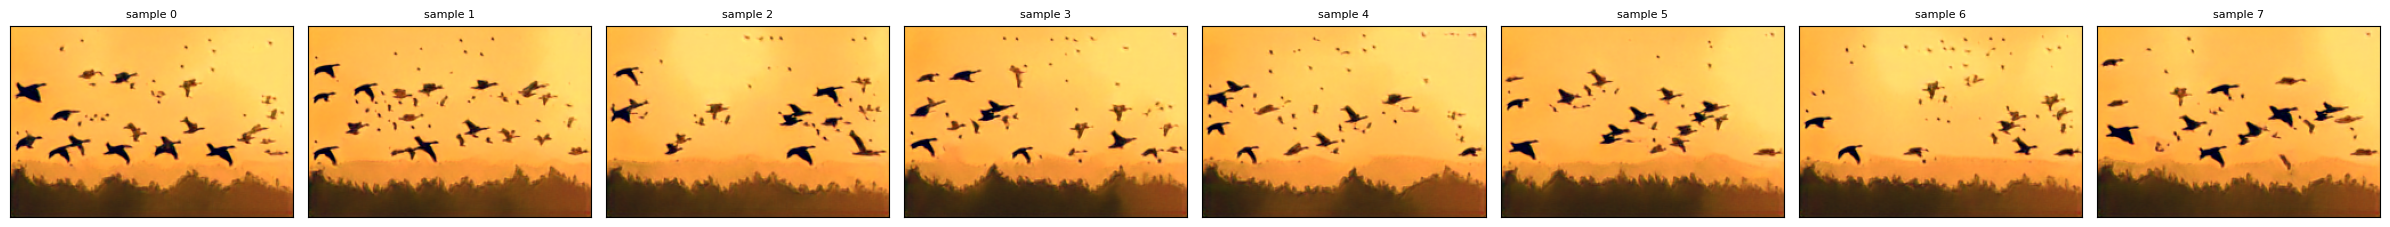

In [93]:
# Nombre de générations
K = 8                       
final_imgs = []
for _ in range(K):
    imgs = generate_multiscale(start_scale=N-1)   # génération du début à la fin
    final_imgs.append(imgs[-1].cpu().squeeze())   

cell = 3.0                                  
fig, axes = plt.subplots(1, K, figsize=(cell*K, cell), squeeze=False)

for c, (ax, img) in enumerate(zip(axes[0], final_imgs)):
    ax.imshow(pil_from_minus1to1(img))
    ax.set_title(f"sample {c}", fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


Reconstruction de XREC

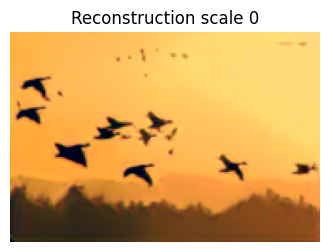

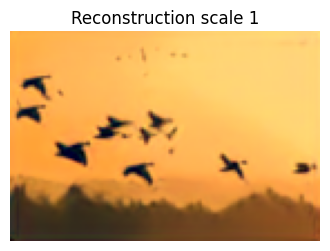

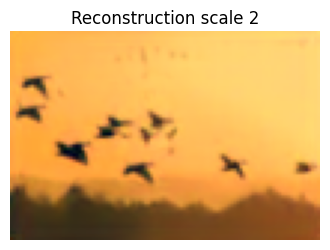

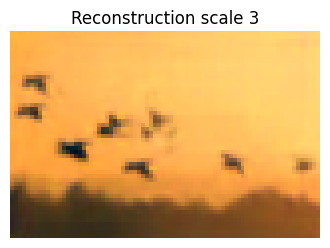

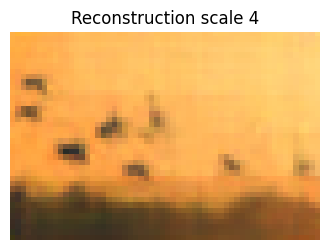

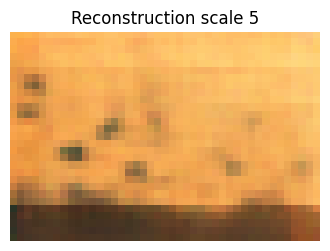

In [100]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec, scales):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:],scales)